In [2]:
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import shutil
import os
import csv
from io import StringIO
import random
import re
from Bio.SeqRecord import SeqRecord
import torch
from pycaret.classification import *
import json
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
# 1. 80:20(224633 : 56159) random also pos_neg = 1:1
# positive = negative = 140396

In [4]:
df = pd.read_csv("6_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)

In [6]:
df

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0002.1,Q01196,AATTGTGGTTA,0.995146,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
1,MA0002.1,Q01196,ATCTGTGGTTA,0.956311,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
2,MA0002.1,Q01196,TTCTGCGGTTA,0.922330,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
3,MA0002.1,Q01196,AATTGCGGTAA,0.917476,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
4,MA0002.1,Q01196,TATTGCGGTTT,0.932039,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
...,...,...,...,...,...,...
280787,MA1986.1,Q9BU19,GAACTTACATX,0.099733,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
280788,MA1986.1,Q9BU19,CAACAAACATX,0.077105,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
280789,MA1986.1,Q9BU19,ATTCGTTTATX,0.066380,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
280790,MA1986.1,Q9BU19,TTACATATAAX,0.087408,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...


In [7]:
training1_pos = df[df['Label'] == 1].sample(frac=0.8, random_state=1)
testing1_pos = df[df['Label'] == 1].drop(training1_pos.index)

training1_neg = df[df['Label'] == 0].sample(frac=0.8, random_state=1)
testing1_neg = df[df['Label'] == 0].drop(training1_neg.index)

training1 = pd.concat([training1_pos, training1_neg], ignore_index=True)
testing1 = pd.concat([testing1_pos, testing1_neg], ignore_index=True)

In [8]:
training1

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0258.1,Q92731,GCCACCGACTC,0.711950,1,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...
1,MA1107.2,Q13886,CCCCACCCTCC,0.829667,1,MSAAAYMDFVAAQCLVSISNRAAVPEHGVAPDAERLRLPEREVTKE...
2,MA0081.2,Q01892,TACTTCTTCTG,0.726333,1,MLALEAAQLDGPHFSCLYPDGVFYDLDSCKHSSYPDSEGAPDSLWD...
3,MA0114.4,P41235,ACAAAGTCCTT,0.890598,1,MRLSKTLVDMDMADYSAALDPAYTTLEFENVQVLTMGNDTSPSEGT...
4,MA0814.2,Q92754,ACCTGCCGCGT,0.730408,1,MLWKITDNVKYEEDCEDRHDGSSNGNPRVPHLSSAGQHLYSPAPPL...
...,...,...,...,...,...,...
224629,MA1121.1,Q15562,ACACACATCCG,0.155325,0,MGEPRAGAALDDGSGWTGSEEGSEEGTGGSEGAGGDGGPDAEGVWS...
224630,MA0620.3,O75030,TGTTATCAGTT,0.229674,0,MQSESGIVPDFEVGEEFHEEPKTYYELKSQPLKSSSSAEHPGASKP...
224631,MA0745.2,O43623,GTGCTGACAAT,0.123708,0,MPRSFLVKKHFNASKKPNYSELDTHTVIISPYLYESYSMPVIPQPE...
224632,MA0147.3,P01106,ATGTATGATGG,0.131904,0,MDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...


In [9]:
testing1

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0002.1,Q01196,AATTGTGGTTA,0.995146,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
1,MA0002.1,Q01196,TATTGTGGTAG,0.917476,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
2,MA0002.1,Q01196,AACTGCGGTTG,0.878641,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
3,MA0002.1,Q01196,CTTTGCGGTTA,0.912621,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
4,MA0002.1,Q01196,AAATGTGGTAC,0.854369,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
...,...,...,...,...,...,...
56153,MA1986.1,Q9BU19,GTACATATTTX,0.101382,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
56154,MA1986.1,Q9BU19,CCATGTATACX,0.096531,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
56155,MA1986.1,Q9BU19,TCACGAACCTX,0.131015,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
56156,MA1986.1,Q9BU19,ATTCGTACCGX,0.129715,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...


In [37]:
with open('6_protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('6_one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('6_Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)

In [ ]:
peseq = protein_embedding_sequence[training1['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[training1['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[training1['DNA_Sequence'][0]]

training = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

training1_feature = pd.DataFrame.from_dict(training, orient='index')
for i in range(len(training1)):
    print(i)
    peseq = protein_embedding_sequence[training1['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[training1['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[training1['DNA_Sequence'][i]]
    name = str(i)
    training1_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]

In [39]:
training1_feature

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,-0.002948,-0.002335,-0.015625,-0.022707,-0.024158,-0.002981,-0.011018,-0.024943,-0.031998,-0.017779,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.014518,-0.003701,-0.020209,-0.018271,-0.029401,-0.007733,-0.013668,-0.026010,-0.027676,-0.010289,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.006594,-0.011881,-0.021094,-0.018286,-0.019621,-0.009765,-0.005873,-0.018330,-0.020545,-0.023735,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.007294,-0.006613,-0.021188,-0.023279,-0.022387,-0.003038,-0.006053,-0.023679,-0.030497,-0.020677,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.002904,-0.015823,-0.019966,-0.021471,-0.020766,-0.001826,-0.007184,-0.021215,-0.026025,-0.020393,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,-0.013612,-0.031185,-0.015039,-0.018477,-0.011590,-0.002614,-0.003174,-0.020580,-0.026674,-0.031677,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1569,-0.000844,-0.014036,-0.015465,-0.012514,-0.023681,-0.008265,-0.002055,-0.016170,-0.020259,-0.022946,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1570,-0.019380,-0.008876,-0.017869,-0.025646,-0.017708,-0.002925,-0.016797,-0.026565,-0.036883,-0.012422,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1571,-0.009327,-0.013778,-0.028941,-0.018926,-0.031348,-0.005116,-0.008608,-0.020218,-0.027643,-0.011920,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
training1_feature['Label'] = training1['Label'].tolist()
training1_feature.to_csv('8_Classification_1/training.csv', index=False)

In [ ]:
peseq = protein_embedding_sequence[testing1['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[testing1['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[testing1['DNA_Sequence'][0]]

testing = {
    '0': peseq + [int(char) for char in ohe_dna] + word2vec_dna
}

testing1_feature = pd.DataFrame.from_dict(testing, orient='index')
for i in range(len(testing1))[0:10]:
    print(i)
    peseq = protein_embedding_sequence[testing1['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[testing1['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[testing1['DNA_Sequence'][i]]
    name = str(i)
    testing1_feature.loc[name] = peseq + [int(char) for char in ohe_dna] + word2vec_dna

In [ ]:
testing1_feature['Label'] = testing1['Label'].tolist()
testing1_feature.to_csv('8_Classification_1/testing.csv', index=False)

In [ ]:
# 2. one protein -> train80, test20

In [40]:
df = pd.read_csv("6_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)

In [41]:
protein_ls = list(set(df['Uniprot_ID']))

In [42]:
training2 = pd.DataFrame(columns=['Matrix_ID',
                                  'Uniprot_ID',
                                  'DNA_Sequence',
                                  'score/max_score',
                                  'Label',
                                  'protein_sequence'])
testing2 = pd.DataFrame(columns=['Matrix_ID',
                                  'Uniprot_ID',
                                  'DNA_Sequence',
                                  'score/max_score',
                                  'Label',
                                  'protein_sequence'])
for protein in protein_ls:
    temp = df[df['Uniprot_ID'] == protein]
    training2_pos_temp = temp[temp['Label'] == 1].sample(frac=0.8, random_state=1)
    testing2_pos_temp = temp[temp['Label'] == 1].drop(training2_pos_temp.index)
    
    training2_neg_temp = temp[temp['Label'] == 0].sample(frac=0.8, random_state=1)
    testing2_neg_temp = temp[temp['Label'] == 0].drop(training2_neg_temp.index)
    
    training2_temp = pd.concat([training2_pos_temp, training2_neg_temp], ignore_index=True)
    testing2_temp = pd.concat([testing2_pos_temp, testing2_neg_temp], ignore_index=True)
    
    training2 = pd.concat([training2, training2_temp], ignore_index=True)
    testing2 = pd.concat([testing2, testing2_temp], ignore_index=True)

In [43]:
with open('protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)

In [30]:
training2

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA1654.1,P17020,CAGCCATGCAA,0.744340,1,MPSLRTRREEAEMELSVPGPSPWTPAAQARVRDAPAVTHPGSAACG...
1,MA1654.1,P17020,GAGCCATGGAA,0.851213,1,MPSLRTRREEAEMELSVPGPSPWTPAAQARVRDAPAVTHPGSAACG...
2,MA1654.1,P17020,GAGCTATGGAA,0.807278,1,MPSLRTRREEAEMELSVPGPSPWTPAAQARVRDAPAVTHPGSAACG...
3,MA1654.1,P17020,GAGCCATCGCC,0.844003,1,MPSLRTRREEAEMELSVPGPSPWTPAAQARVRDAPAVTHPGSAACG...
4,MA1654.1,P17020,GAGCTATGGGA,0.684838,1,MPSLRTRREEAEMELSVPGPSPWTPAAQARVRDAPAVTHPGSAACG...
...,...,...,...,...,...,...
224625,MA0161.2,P08651,GCACAACGGAC,0.134563,0,MYSSPLCLTQDEFHPFIEALLPHVRAFAYTWFNLQARKRKYFKKHE...
224626,MA0161.2,P08651,GCGCGTATTAT,0.137161,0,MYSSPLCLTQDEFHPFIEALLPHVRAFAYTWFNLQARKRKYFKKHE...
224627,MA0161.1,P08651,GAACGTXXXXX,0.061554,0,MYSSPLCLTQDEFHPFIEALLPHVRAFAYTWFNLQARKRKYFKKHE...
224628,MA0161.2,P08651,GGTAATCACAT,0.130722,0,MYSSPLCLTQDEFHPFIEALLPHVRAFAYTWFNLQARKRKYFKKHE...


In [ ]:
peseq2 = protein_embedding_sequence[training2['Uniprot_ID'][0]]
ohe_dna2 = one_hot_encoding_DNA[training2['DNA_Sequence'][0]]
word2vec_dna2 = Word2Vec_encoding_DNA[training2['DNA_Sequence'][0]]

training = {
    '0': peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
}

training2_feature = pd.DataFrame.from_dict(training, orient='index')
for i in range(len(training2)):
    print(i)
    peseq2 = protein_embedding_sequence[training2['Uniprot_ID'][i]]
    ohe_dna2 = one_hot_encoding_DNA[training2['DNA_Sequence'][i]]
    word2vec_dna2 = Word2Vec_encoding_DNA[training2['DNA_Sequence'][i]]
    name = str(i)
    training2_feature.loc[name] = peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
    
training2_feature['Label'] = training2['Label'].tolist()
training2_feature.to_csv('8_Classification_2/training.csv', index=False)

In [ ]:
peseq2 = protein_embedding_sequence[testing2['Uniprot_ID'][0]]
ohe_dna2 = one_hot_encoding_DNA[testing2['DNA_Sequence'][0]]
word2vec_dna2 = Word2Vec_encoding_DNA[testing2['DNA_Sequence'][0]]

testing = {
    '0': peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
}

testing2_feature = pd.DataFrame.from_dict(testing, orient='index')
for i in range(len(testing2)):
    print(i)
    peseq2 = protein_embedding_sequence[testing2['Uniprot_ID'][i]]
    ohe_dna2 = one_hot_encoding_DNA[testing2['DNA_Sequence'][i]]
    word2vec_dna2 = Word2Vec_encoding_DNA[testing2['DNA_Sequence'][i]]
    name = str(i)
    testing2_feature.loc[name] = peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
    
testing2_feature['Label'] = testing2['Label'].tolist()
testing2_feature.to_csv('8_Classification_2/testing.csv', index=False)

In [ ]:
# 3.

In [2]:
df = pd.read_csv("6_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0002.1,Q01196,AATTGTGGTTA,0.995146,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
1,MA0002.1,Q01196,ATCTGTGGTTA,0.956311,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
2,MA0002.1,Q01196,TTCTGCGGTTA,0.922330,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
3,MA0002.1,Q01196,AATTGCGGTAA,0.917476,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
4,MA0002.1,Q01196,TATTGCGGTTT,0.932039,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
...,...,...,...,...,...,...
280787,MA1986.1,Q9BU19,GAACTTACATX,0.099733,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
280788,MA1986.1,Q9BU19,CAACAAACATX,0.077105,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
280789,MA1986.1,Q9BU19,ATTCGTTTATX,0.066380,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
280790,MA1986.1,Q9BU19,TTACATATAAX,0.087408,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...


In [3]:
protein_count = df['Uniprot_ID'].value_counts().reset_index()
protein_count.columns = ['Uniprot_ID', 'Count']

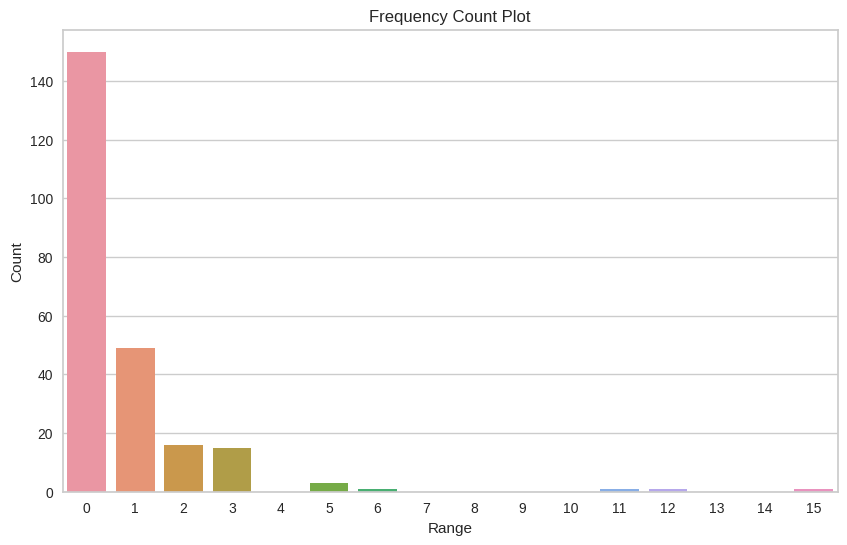

In [4]:
bins = list(range(0, 16001, 1000))
Labels = list(range(0, 16))

protein_count['range'] = pd.cut(protein_count['Count'], bins=bins,
                                labels=Labels,
                                right=False)

bin_counts = protein_count['range'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values)
plt.title('Frequency Count Plot')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

In [5]:
protein_count

,Uniprot_ID,Count,range
0,P49711,15634,15
1,O75030,12938,12
2,Q9ULX9,11780,11
3,O60675,6584,6
4,Q9H3D4,5334,5
...,...,...,...
232,Q92766,16,0
233,O43524,14,0
234,Q01101,14,0
235,Q99801,12,0


In [30]:
training3_protein = ['P49711']
testing3_protein = ['O75030','Q9ULX9']
range_ls = list(set(protein_count['range']))
range_ls.remove(11)
range_ls.remove(12)
range_ls.remove(15)
random.seed(1)
for count_range in range_ls:
    temp_range_df = protein_count[protein_count['range'] == count_range]
    temp_protein_id = temp_range_df['Uniprot_ID'].tolist()
    random.shuffle(temp_protein_id)
    split_index = int(0.8 * len(temp_protein_id))

    training3_protein += temp_protein_id[:split_index]
    testing3_protein += temp_protein_id[split_index:]

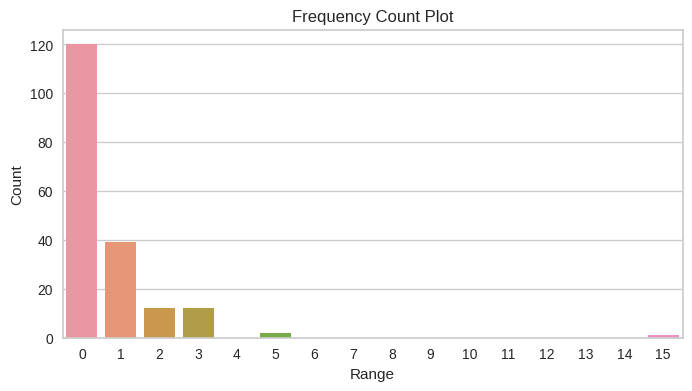

In [33]:
zzz = protein_count[protein_count['Uniprot_ID'].isin(training3_protein)]

zzzbin_counts = zzz['range'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=zzzbin_counts.index, y=zzzbin_counts.values)
plt.title('Frequency Count Plot')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

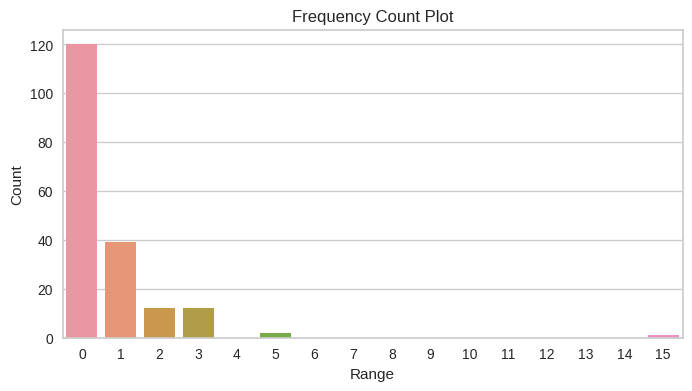

In [34]:
zzzz = protein_count[protein_count['Uniprot_ID'].isin(testing3_protein)]

zzzzbin_counts = zzz['range'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=zzzzbin_counts.index, y=zzzzbin_counts.values)
plt.title('Frequency Count Plot')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

In [35]:
training_df = df[df['Uniprot_ID'].isin(training3_protein)]
training_df.reset_index(drop=True, inplace=True)
training_df

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0014.2,Q02548,GCAGCCAAGCA,0.952603,1,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...
1,MA0014.2,Q02548,GCAACCAAGCG,0.925234,1,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...
2,MA0014.2,Q02548,CCAGTCAAGCA,0.903872,1,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...
3,MA0014.2,Q02548,TCAGCCAAGCG,0.890235,1,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...
4,MA0014.2,Q02548,GCAACCAACCA,0.866775,1,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...
...,...,...,...,...,...,...
195985,MA1986.1,Q9BU19,GAACTTACATX,0.099733,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
195986,MA1986.1,Q9BU19,CAACAAACATX,0.077105,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
195987,MA1986.1,Q9BU19,ATTCGTTTATX,0.066380,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...
195988,MA1986.1,Q9BU19,TTACATATAAX,0.087408,0,MASSPAVDVSCRRREKRRQLDARRSKCRIRLGGHMEQWCLLKERLG...


In [36]:
testing_df = df[df['Uniprot_ID'].isin(testing3_protein)]
testing_df.reset_index(drop=True, inplace=True)
testing_df

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0002.1,Q01196,AATTGTGGTTA,0.995146,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
1,MA0002.1,Q01196,ATCTGTGGTTA,0.956311,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
2,MA0002.1,Q01196,TTCTGCGGTTA,0.922330,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
3,MA0002.1,Q01196,AATTGCGGTAA,0.917476,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
4,MA0002.1,Q01196,TATTGCGGTTT,0.932039,1,MRIPVDASTSRRFTPPSTALSPGKMSEALPLGAPDAGAALAGKLRS...
...,...,...,...,...,...,...
84797,MA1970.1,Q9UHF7,CGTAGCCGCGG,0.135703,0,MVRKKNPPLRNVASEGEGQILEPIGTESKVSGKNKEFSADQMSENT...
84798,MA1970.1,Q9UHF7,CGAGCCGAAGC,0.149903,0,MVRKKNPPLRNVASEGEGQILEPIGTESKVSGKNKEFSADQMSENT...
84799,MA1970.1,Q9UHF7,GTGCCCCAGTG,0.207112,0,MVRKKNPPLRNVASEGEGQILEPIGTESKVSGKNKEFSADQMSENT...
84800,MA1970.1,Q9UHF7,TTGACCAGCGA,0.241126,0,MVRKKNPPLRNVASEGEGQILEPIGTESKVSGKNKEFSADQMSENT...


In [37]:
with open('protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)

In [ ]:
peseq = protein_embedding_sequence[training_df['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[training_df['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[training_df['DNA_Sequence'][0]]

training = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

training3_feature = pd.DataFrame.from_dict(training, orient='index')
for i in range(len(training_df))[0:10]:
    print("training: " + str(i))
    peseq = protein_embedding_sequence[training_df['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[training_df['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[training_df['DNA_Sequence'][i]]
    name = str(i)
    training3_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]
    
training3_feature['Label'] = training_df['Label'].tolist()
training3_feature.to_csv('8_Classification_1/training.csv', index=False)

In [ ]:
peseq = protein_embedding_sequence[testing_df['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[testing_df['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[testing_df['DNA_Sequence'][0]]

testing = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

testing3_feature = pd.DataFrame.from_dict(testing, orient='index')
for i in range(len(testing_df)):
    print("training: " + str(i))
    peseq = protein_embedding_sequence[testing_df['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[testing_df['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[testing_df['DNA_Sequence'][i]]
    name = str(i)
    testing3_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]
    
testing3_feature['Label'] = testing_df['Label'].tolist()
testing3_feature.to_csv('8_Classification_1/testing.csv', index=False)